<img src='../images/ga_logo_large.png' style="display: block; margin-left: auto; margin-right: auto;">

---
## **Project 4: Stocks and Portfolios**

---
### **Pre Processing and Model Training**

----
**Imports**

In [88]:
# import needed libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

---
**Read in Data**

In [16]:
input_path1 = '../data/clean_data/stocks-clean-data-2.csv'
input_path2 = '../data/clean_data/stock-correlations.csv'

stocks = pd.read_csv(input_path1)
stock_corrs = pd.read_csv(input_path2)

Confirm dimensionality

In [58]:
print(stocks.shape)
print('-'*15)
print(stock_corrs.shape)

(26308, 13)
---------------
(503, 5)


Check some rows

In [28]:
stocks.head(2)

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06


In [30]:
stocks.tail(2)

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date
26306,13654984.0,17.5333,17.03,18.17,18.69,15.15,1667707200000,138506,NWS,3.54,1.14,6.694069,2022-11-06
26307,13034580.0,17.0190,17.34,16.92,17.66,16.20,1666497600000,113603,NWS,1.46,0.42,-2.422145,2022-10-23


In [32]:
stock_corrs.head(2)

,symbol,corr_weighted_vol_vs_volatility,corr_weighted_vol_vs_price_range,corr_price_range_vs_volatility,avg_pct_change
0,A,0.196730,0.134928,0.887184,0.191745
1,AAPL,0.095399,0.167993,0.653506,1.137613


In [34]:
stock_corrs.tail(2)

,symbol,corr_weighted_vol_vs_volatility,corr_weighted_vol_vs_price_range,corr_price_range_vs_volatility,avg_pct_change
501,ZBRA,-0.047176,-0.039267,0.664490,0.910028
502,ZTS,-0.329070,-0.319157,0.741497,0.499683


----
**Missing Values and Data Types**

In [37]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26308 entries, 0 to 26307
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   trading_volume           26308 non-null  float64
 1   weighted_volume          26308 non-null  float64
 2   open_price               26308 non-null  float64
 3   close_price              26308 non-null  float64
 4   highest_price            26308 non-null  float64
 5   lowest_price             26308 non-null  float64
 6   timestamp                26308 non-null  int64  
 7   transactions             26308 non-null  int64  
 8   symbol                   26308 non-null  object 
 9   price_range              26308 non-null  float64
 10  volatility               26308 non-null  float64
 11  price_change_percentage  26308 non-null  float64
 12  date                     26308 non-null  object 
dtypes: float64(9), int64(2), object(2)
memory usage: 2.6+ MB


In [39]:
stock_corrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   symbol                            503 non-null    object 
 1   corr_weighted_vol_vs_volatility   503 non-null    float64
 2   corr_weighted_vol_vs_price_range  503 non-null    float64
 3   corr_price_range_vs_volatility    503 non-null    float64
 4   avg_pct_change                    503 non-null    float64
dtypes: float64(4), object(1)
memory usage: 19.8+ KB


The data was previously cleaned, so everything looks good, as expected.

---
**Pre-processing Stage**<br>
Use all numeric features.

In [491]:
# set a random seed for reproducibility
np.random.seed(2024)

In [561]:
# keep track of metrics for each model iteration on this list
# input format to append {k: value, n_init: value, inertia: value, silhouette: value, remarks: text}
metrics = []

Scale Features

In [495]:
# instantiate standard scaler
sc = StandardScaler()

# scale data ----------------------------------------------------------

# drop non-numeric columns from stocks df
# symbol: 503 unique values, too many to encode
# date: does not make sense to keep as
# there is already a timestamp column in ms
stocks_sc1 = sc.fit_transform(stocks.drop(columns = ['symbol', 'date']))         


# mainly because of the avg_pct_change column, slightly greater scale
# all other columns are in the same scale
# drop symbol column
stock_corrs_sc1 = sc.fit_transform(stock_corrs.drop(columns = 'symbol')) 

Build pipeline with a StandardScaler and a KMeans model

In [497]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('km', KMeans(random_state = 2024))
])

Set parameters to search over

In [499]:
params = {
    'km__n_clusters': [*range(3, 12)],
    'km__n_init': [10, 20, 30]
}

Instantiate GridSearchCV object

In [501]:
gs1 = GridSearchCV(
    pipe,
    param_grid = params,
    n_jobs = -1,
    verbose = 1
)

---
**Modeling and Clustering**

Determine best parameters to use to initially instantiate KMeans model

In [503]:
# fit gridsearch with all numeric columns
gs1.fit(stocks.drop(columns = ['symbol', 'date']))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('km', KMeans(random_state=2024))]),
             n_jobs=-1,
             param_grid={'km__n_clusters': [3, 4, 5, 6, 7, 8, 9, 10, 11],
                         'km__n_init': [10, 20, 30]},
             verbose=1)

In [505]:
gs1.best_params_

{'km__n_clusters': 11, 'km__n_init': 10}

In [552]:
# fit KMeans model based on the best parameters
km1 = KMeans(
    n_clusters = gs1.best_params_['km__n_clusters'],
    n_init = gs1.best_params_['km__n_init'],
    random_state = 2024
)

km1.fit(stocks_sc1)

KMeans(n_clusters=11, n_init=10, random_state=2024)

In [554]:
# get cluster labels
set(km1.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

No outliers were identified as -1 is not present in the set.

In [557]:
# check inertia score
km1.inertia_

63630.0458485182

In [559]:
# check silhouette score
silhouette_score(stocks_sc1, km1.labels_)

0.3337250762191138

In [563]:
# store results
results = {
    'clusters': gs1.best_params_['km__n_clusters'],
    'n_init': gs1.best_params_['km__n_init'],
    'inertia': round(km1.inertia_, 0),
    'silhouette': round(silhouette_score(stocks_sc1, km1.labels_), 3),
    'remarks': 'Cluster A: All numeric features',
    'reference': 'stocks_sc1, gs1, km1'
}

metrics.append(results)

In [564]:
# add clusters to original dataset
stocks['cluster_a'] = km1.labels_

# confirm
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,cluster_a
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,3
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,4
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,4
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,4
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,4


In [567]:
# check number of unique stocks per cluster
stocks.groupby('cluster_a')['symbol'].unique()

cluster_a
0     [META, BRK.B, AVGO, GOOG, LLY, JPM, XOM, UNH, ...
1     [MSFT, META, GOOGL, BRK.B, AVGO, GOOG, JPM, XO...
2                           [BKNG, AZO, FICO, NVR, MTD]
3     [AAPL, AMZN, GOOGL, AVGO, GOOG, JPM, TSLA, XOM...
4     [AAPL, NVDA, MSFT, AMZN, META, GOOGL, AVGO, GO...
5                                                 [NVR]
6                              [AAPL, NVDA, AMZN, TSLA]
7     [MSFT, META, BRK.B, LLY, UNH, V, MA, HD, COST,...
8     [META, LLY, UNH, COST, NFLX, TMO, ADBE, NOW, I...
9                                                [NVDA]
10                                                [NVR]
Name: symbol, dtype: object

In [569]:
# check number of unique stocks per cluster
stocks.groupby('cluster_a')['symbol'].nunique()

cluster_a
0     483
1     457
2       5
3     448
4      32
5       1
6       4
7     177
8      48
9       1
10      1
Name: symbol, dtype: int64

Although the gridsearch settled on 11 clusters, let's see what the silhouette scores are for various values between 3 and 11.<br>
Leave all other parameters at their default values.

In [571]:
# lets check k from 3 to 11
silhouette_scores = []
for k in range(3, 12):
    kmeans = KMeans(n_clusters = k, random_state = 2024)
    kmeans.fit(stocks_sc1)
    silhouette_scores.append(round(silhouette_score(stocks_sc1, kmeans.labels_), 2))

silhouette_scores

[0.49, 0.31, 0.33, 0.33, 0.35, 0.34, 0.32, 0.33, 0.31]

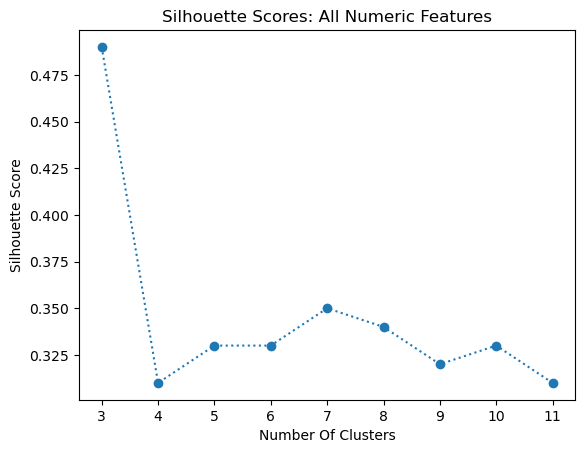

In [573]:
plt.plot(range(3, 12), silhouette_scores, marker = 'o', linestyle = ':');
plt.title('Silhouette Scores: All Numeric Features')
plt.xlabel('Number Of Clusters')
plt.ylabel('Silhouette Score');

---
**Pre-processing Stage**<br>
Use only the three engineered features: `price_range`, `volatility`, `price_change_percentage`.

Scale Features

In [575]:
# standard scaler is already instantiated as sc
# scale data, just three engineered features
stocks_sc2 = sc.fit_transform(stocks[['price_range', 'volatility', 'price_change_percentage']])         

The pipeline steps and parameters stay the same, only another instance of the gridsearch must be setup to search over a reduced number of features.

In [578]:
gs2 = GridSearchCV(
    pipe,
    param_grid = params,
    n_jobs = -1,
    verbose = 1
)

---
**Modeling and Clustering**

Determine best parameters for second iteration...

In [582]:
gs2.fit(stocks[['price_range', 'volatility', 'price_change_percentage']])

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('km', KMeans(random_state=2024))]),
             n_jobs=-1,
             param_grid={'km__n_clusters': [3, 4, 5, 6, 7, 8, 9, 10, 11],
                         'km__n_init': [10, 20, 30]},
             verbose=1)

In [584]:
gs2.best_params_

{'km__n_clusters': 11, 'km__n_init': 20}

In [586]:
# fit KMeans model based on the best parameters
km2 = KMeans(
    n_clusters = gs2.best_params_['km__n_clusters'],
    n_init = gs2.best_params_['km__n_init'],
    random_state = 2024
)

km2.fit(stocks_sc2)

KMeans(n_clusters=11, n_init=20, random_state=2024)

In [588]:
set(km2.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [590]:
km2.inertia_

12215.044127925159

In [592]:
silhouette_score(stocks_sc2, km2.labels_)

0.3700274157657033

In [594]:
# store results
results = {
    'clusters': gs2.best_params_['km__n_clusters'],
    'n_init': gs2.best_params_['km__n_init'],
    'inertia': round(km2.inertia_, 0),
    'silhouette': round(silhouette_score(stocks_sc2, km2.labels_), 3),
    'remarks': 'Cluster B: Three engineered features',
    'reference': 'stocks_sc2, gs2, km2'
}

metrics.append(results)

In [596]:
# add clusters to original dataset
stocks['cluster_b'] = km2.labels_

# confirm
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,cluster_a,cluster_b
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,3,0
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,4,4
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,4,0
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,4,4
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,4,5


In [598]:
# check number of unique stocks per cluster
stocks.groupby('cluster_b')['symbol'].unique()

cluster_b
0     [AAPL, NVDA, MSFT, AMZN, META, GOOGL, BRK.B, A...
1                           [BKNG, AZO, NVR, MTD, TECH]
2     [AAPL, NVDA, MSFT, AMZN, META, GOOGL, BRK.B, A...
3     [META, LLY, UNH, COST, NFLX, TMO, ADBE, NOW, I...
4     [AAPL, NVDA, MSFT, AMZN, META, GOOGL, BRK.B, A...
5     [AAPL, NVDA, MSFT, AMZN, META, GOOGL, BRK.B, A...
6                                                [TECH]
7                                                 [NVR]
8     [AAPL, MSFT, META, GOOGL, BRK.B, GOOG, LLY, TS...
9     [LLY, BKNG, REGN, KLAC, AZO, FICO, MPWR, NVR, ...
10    [AAPL, NVDA, MSFT, AMZN, META, GOOGL, AVGO, GO...
Name: symbol, dtype: object

In [600]:
# check number of unique stocks per cluster
stocks.groupby('cluster_b')['symbol'].nunique()

cluster_b
0     499
1       5
2     327
3      48
4     480
5     497
6       1
7       1
8     154
9       9
10    323
Name: symbol, dtype: int64

In [602]:
# lets check k from 3 to 11
silhouette_scores = []
for k in range(3, 12):
    kmeans = KMeans(n_clusters = k, random_state = 2024)
    kmeans.fit(stocks_sc2)
    silhouette_scores.append(round(silhouette_score(stocks_sc2, kmeans.labels_), 2))

silhouette_scores

[0.39, 0.39, 0.39, 0.41, 0.38, 0.37, 0.37, 0.37, 0.38]

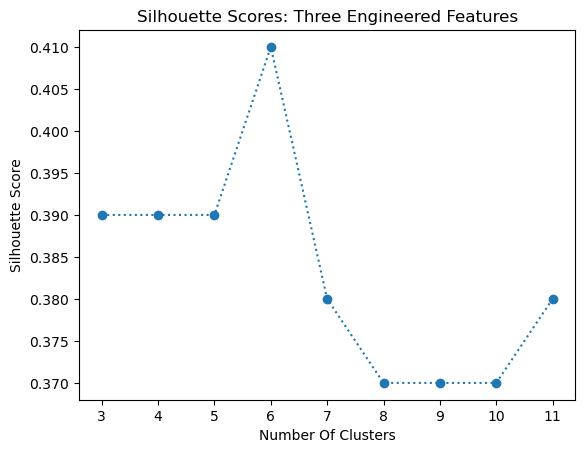

In [604]:
plt.plot(range(3, 12), silhouette_scores, marker = 'o', linestyle = ':');
plt.title('Silhouette Scores: Three Engineered Features')
plt.xlabel('Number Of Clusters')
plt.ylabel('Silhouette Score');

---
**Pre-processing Stage**<br>
Use only two strongest engineered features: `price_range` and `volatility`.

Scale features

In [611]:
# standard scaler is already instantiated as sc
# scale data, just three engineered features
stocks_sc3 = sc.fit_transform(stocks[['price_range', 'volatility']])         

Same, just instantiate new gridsearch object

In [614]:
gs3 = GridSearchCV(
    pipe,
    param_grid = params,
    n_jobs = -1,
    verbose = 1
)

---
**Modeling and Clustering**

Third iteration...

In [619]:
gs3.fit(stocks[['price_range', 'volatility']])

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('km', KMeans(random_state=2024))]),
             n_jobs=-1,
             param_grid={'km__n_clusters': [3, 4, 5, 6, 7, 8, 9, 10, 11],
                         'km__n_init': [10, 20, 30]},
             verbose=1)

In [621]:
gs3.best_params_

{'km__n_clusters': 11, 'km__n_init': 10}

In [623]:
# fit KMeans model based on the best parameters
km3 = KMeans(
    n_clusters = gs3.best_params_['km__n_clusters'],
    n_init = gs3.best_params_['km__n_init'],
    random_state = 2024
)

km3.fit(stocks_sc3)

KMeans(n_clusters=11, n_init=10, random_state=2024)

In [625]:
set(km3.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [627]:
km3.inertia_

3288.10190134788

In [629]:
silhouette_score(stocks_sc3, km3.labels_)

0.5354709637740718

In [649]:
# store results
results = {
    'clusters': gs3.best_params_['km__n_clusters'],
    'n_init': gs3.best_params_['km__n_init'],
    'inertia': round(km3.inertia_, 0),
    'silhouette': round(silhouette_score(stocks_sc3, km3.labels_), 3),
    'remarks': 'Cluster C: Best Two engineered features',
    'reference': 'stocks_sc3, gs3, km3'
}

metrics.append(results)

In [633]:
# add clusters to original dataset
stocks['cluster_c'] = km3.labels_

# confirm
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,cluster_a,cluster_b,cluster_c
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,3,0,4
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,4,4,0
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,4,0,4
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,4,4,0
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,4,5,0


In [635]:
# check number of unique stocks per cluster
stocks.groupby('cluster_c')['symbol'].unique()

cluster_c
0     [AAPL, NVDA, MSFT, AMZN, META, GOOGL, BRK.B, A...
1                                           [BKNG, NVR]
2          [LLY, BKNG, REGN, AZO, FICO, MPWR, NVR, MTD]
3     [META, LLY, COST, NFLX, TMO, ADBE, NOW, INTU, ...
4     [AAPL, NVDA, MSFT, AMZN, META, GOOGL, BRK.B, A...
5     [MSFT, META, AVGO, LLY, TSLA, UNH, HD, COST, N...
6                                                 [NVR]
7                                            [AZO, NVR]
8                           [BKNG, AZO, NVR, MTD, TECH]
9     [AAPL, NVDA, MSFT, AMZN, META, GOOGL, BRK.B, A...
10    [BKNG, KLAC, TDG, SNPS, AZO, FICO, MPWR, NVR, ...
Name: symbol, dtype: object

In [637]:
# check number of unique stocks per cluster
stocks.groupby('cluster_c')['symbol'].nunique()

cluster_c
0     410
1       2
2       8
3      46
4     470
5     121
6       1
7       2
8       5
9     255
10      9
Name: symbol, dtype: int64

In [639]:
# lets check k from 3 to 11
silhouette_scores = []
for k in range(3, 12):
    kmeans = KMeans(n_clusters = k, random_state = 2024)
    kmeans.fit(stocks_sc3)
    silhouette_scores.append(round(silhouette_score(stocks_sc3, kmeans.labels_), 2))

silhouette_scores

[0.86, 0.73, 0.67, 0.67, 0.61, 0.57, 0.53, 0.49, 0.44]

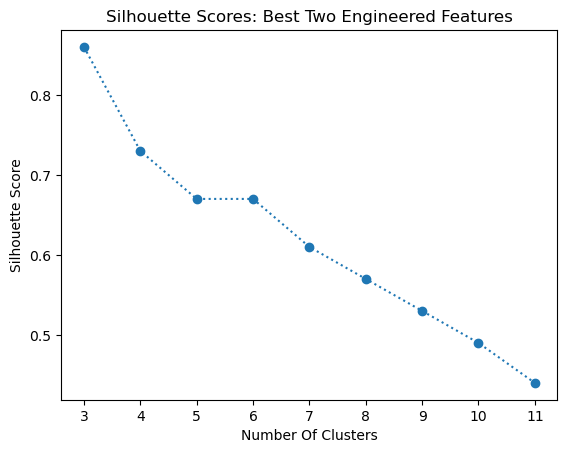

In [641]:
plt.plot(range(3, 12), silhouette_scores, marker = 'o', linestyle = ':');
plt.title('Silhouette Scores: Best Two Engineered Features')
plt.xlabel('Number Of Clusters')
plt.ylabel('Silhouette Score');

In [653]:
# fit KMeans model based on the best parameters
km4 = KMeans(
    n_clusters = 3,
    n_init = 10,
    random_state = 2024
)

km4.fit(stocks_sc3)

KMeans(n_clusters=3, n_init=10, random_state=2024)

In [655]:
set(km4.labels_)

{0, 1, 2}

In [657]:
km4.inertia_

15351.665357175829

In [659]:
silhouette_score(stocks_sc3, km4.labels_)

0.8619816970897448

In [661]:
# add clusters to original dataset
stocks['cluster_d'] = km4.labels_

# confirm
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,cluster_a,cluster_b,cluster_c,cluster_d
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,3,0,4,0
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,4,4,0,0
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,4,0,4,0
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,4,4,0,0
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,4,5,0,0


In [663]:
# check number of unique stocks per cluster
stocks.groupby('cluster_d')['symbol'].nunique()

cluster_d
0    501
1      5
2     91
Name: symbol, dtype: int64

In [667]:
# fit KMeans model based on the best parameters
km5 = KMeans(
    n_clusters = 6,
    n_init = 20,
    random_state = 2024
)

km5.fit(stocks_sc2)

KMeans(n_clusters=6, n_init=20, random_state=2024)

In [671]:
set(km5.labels_)

{0, 1, 2, 3, 4, 5}

In [673]:
km5.inertia_

21669.185433202365

In [677]:
silhouette_score(stocks_sc2, km5.labels_)

0.40603896787512656

In [679]:
# add clusters to original dataset
stocks['cluster_e'] = km5.labels_

# confirm
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,cluster_a,cluster_b,cluster_c,cluster_d,cluster_e
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,3,0,4,0,5
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,4,4,0,0,1
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,4,0,4,0,5
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,4,4,0,0,5
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,4,5,0,0,0


In [681]:
# check number of unique stocks per cluster
stocks.groupby('cluster_e')['symbol'].nunique()

cluster_e
0    498
1    499
2      4
3     72
4      9
5    501
Name: symbol, dtype: int64

In [650]:
pd.DataFrame(metrics)

,clusters,n_init,inertia,silhouette,remarks,reference
0,11,10,63630.0,0.334,Cluster A: All numeric features,"stocks_sc1, gs1, km1"
1,11,20,12215.0,0.370,Cluster B: Three engineered features,"stocks_sc2, gs2, km2"
2,11,10,3288.0,0.535,Cluster C: Best Two engineered features,"stocks_sc3, gs3, km3"
